### Connect to Neo4j and Verify Connection

In [2]:
from py2neo import Graph

# Connect to Neo4j using bolt://localhost:7687
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# Test the connection by running a basic query
result = graph.run("MATCH (n) RETURN COUNT(n)").data()
print(result)

[{'COUNT(n)': 56849}]


### Poster 3 query graph

In [ ]:
import pandas as pd

df_results = pd.read_csv("../data/cache/test_movies_query.csv")
# Extract tconst values from the df_results DataFrame (assuming the column name is 'tconst')
tconst_values = df_results["tconst"].tolist()

directors = []
actors = []
production_cos = []

# Iterate over each tconst and run the query
for tconst in tconst_values:
    # Prepare the dynamic list of tconsts for the query
    tconst_query_list = [tconst]

    # Construct the Cypher query for production companies
    cypher_query = f"""
    MATCH (m:Movie)-[:PRODUCED_BY]->(pc:ProductionCompany)
    WHERE m.tconst IN {tconst_query_list}
    WITH pc.name AS studio, count(*) AS count
    ORDER BY count DESC
    LIMIT 1
    RETURN studio
    """

    # Execute the query and process the result
    result = graph.run(cypher_query)

    # Extract and append the cleaned production company name
    for record in result:
        production_cos.append(record['studio'].strip())  # Strip spaces and append the cleaned production company name

    # Construct the Cypher query for directors
    cypher_query2 = f"""
    MATCH (d:Director)-[:DIRECTED]->(m:Movie)
    WHERE m.tconst IN {tconst_query_list}
    WITH d.name AS director, count(*) AS count
    ORDER BY count DESC
    LIMIT 1
    RETURN director
    """

    # Execute the query and process the result
    result = graph.run(cypher_query2)

    # Extract and append the cleaned director name
    for record in result:
        directors.append(record['director'].strip()) 

    # Construct the Cypher query for top 2 actors
    cypher_query3 = f"""
    MATCH (a:Actor)-[:ACTED_IN]->(m:Movie)
    WHERE m.tconst IN {tconst_query_list}
    WITH a.name AS actor, count(*) AS appearances
    ORDER BY appearances DESC
    LIMIT 2
    RETURN actor
    """

    # Execute the query and process the result
    result = graph.run(cypher_query3)
    # Append the actors for this movie to the local list (clearing it at each iteration)
    actors_for_current_movie = []
    for record in result:
        actors_for_current_movie.append(record['actor'].strip())

    # Append actors list of the current movie to the main actors list
    actors.append(actors_for_current_movie)

# Print the results for directors, production companies, and actors
for record in zip(directors, production_cos, actors):
    print(f"Director: {record[0]}, Production Company: {record[1]}, Actor: {record[2]}")


### Create Budget-Tiered Subgraphs in Neo4j Using Cypher Projection

In [3]:
for tier in ["low", "medium", "high", "tentpole"]:
    graph.run(f"""
        CALL gds.graph.exists('subgraph_{tier}') YIELD exists
        WITH exists WHERE exists
        CALL gds.graph.drop('subgraph_{tier}', false) YIELD graphName
        RETURN graphName
    """)

    graph.run(f"""
        CALL gds.graph.project.cypher(
            'subgraph_{tier}',
            'MATCH (n) WHERE (n:Movie AND n.budgetCategory="{tier}") OR NOT n:Movie RETURN id(n) AS id',
            'MATCH (m:Movie)-[r]-(x)
             WHERE m.budgetCategory = "{tier}"
             RETURN id(m) AS source, id(x) AS target, type(r) AS type',
            {{validateRelationships: false}}
        )
    """)


### Run Louvain Community Detection for Each Budget Tier

In [4]:
for tier in ["low", "medium", "high", "tentpole"]:
    result = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{tier}')
        YIELD nodeId, communityId
        WITH gds.util.asNode(nodeId) AS n, communityId
        WHERE n:Movie
        RETURN n.primaryTitle AS movie, communityId
        ORDER BY communityId ASC
    """).to_data_frame()
    
    print(f"\n--- {tier.upper()} Budget Movies Louvain Communities ---")
    print(result.head(10))


--- LOW Budget Movies Louvain Communities ---
                            movie  communityId
0  Invasion of the Body Snatchers         3403
1  Killer Klowns from Outer Space         3713
2                         Skyline         3778
3                        Woodlawn         4407
4                         Upgrade         4729
5                             Y2K         4823
6                       Westworld         5042
7                        Automata         5062
8                          S1m0ne         5105
9                     Futureworld         5167

--- MEDIUM Budget Movies Louvain Communities ---
                      movie  communityId
0                District 9         3444
1        Invaders from Mars         4250
2            The Blind Side         4419
3             Little Giants         4488
4         American Underdog         4661
5  Air Bud: Golden Receiver         4787
6   Flight of the Navigator         5300
7                  Star Kid         5547
8                

### Count Nodes per Louvain Community for Each Budget Tier

In [5]:
for tier in ["low", "medium", "high", "tentpole"]:
    df = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{tier}')
        YIELD communityId
        RETURN communityId, COUNT(*) AS numMovies
        ORDER BY numMovies DESC
    """).to_data_frame()
    
    print(f"\n--- {tier.upper()} Budget: Movies per Community ---")
    print(df)


--- LOW Budget: Movies per Community ---
       communityId  numMovies
0            46932        586
1            48355        502
2            46336        461
3            47259        267
4            26507        224
...            ...        ...
46278        53214          1
46279        53215          1
46280        53216          1
46281        53217          1
46282        53218          1

[46283 rows x 2 columns]

--- MEDIUM Budget: Movies per Community ---
       communityId  numMovies
0            47305        426
1             6918        399
2            16130        387
3            30766        253
4            25668        243
...            ...        ...
45903         1483          1
45904         1488          1
45905         1490          1
45906         1491          1
45907         1493          1

[45908 rows x 2 columns]

--- HIGH Budget: Movies per Community ---
       communityId  numMovies
0            46955        353
1            45897        270
2       

### Load and Combine Training + Validation Sets (Excluding Indie Tier)

In [6]:
import pandas as pd

df_train = pd.read_csv("../data/cache/poster3_train_graphed.csv")
df_val = pd.read_csv("../data/cache/poster3_val_graphed.csv")
df_test = pd.read_csv("../data/cache/poster3_test.csv")

# Combine training and validation
df_train = pd.concat([df_train, df_val], ignore_index=True)

# Drop 'indie' from both
df_train = df_train[df_train["from_budget_category"] != "indie"].reset_index(drop=True)
df_test = df_test[df_test["from_budget_category"] != "indie"].reset_index(drop=True)

### One-Hot Encode Genres and Subgenres for Test Set

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

def split_tags(col):
    return col.fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])

# Fit on train set
mlb_genre = MultiLabelBinarizer()
mlb_genre.fit(split_tags(df_train["genres"]))

mlb_subgenre = MultiLabelBinarizer()
mlb_subgenre.fit(split_tags(df_train["subgenres"]))

# Transform test set
genre_onehot = pd.DataFrame(
    mlb_genre.transform(split_tags(df_test["genres"])),
    columns=[f"genre_{g}" for g in mlb_genre.classes_]
)
subgenre_onehot = pd.DataFrame(
    mlb_subgenre.transform(split_tags(df_test["subgenres"])),
    columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_]
)

# Merge into df_test
df_test_final = pd.concat([df_test.reset_index(drop=True), genre_onehot, subgenre_onehot], axis=1)

### Merge Louvain Communities with Movie Genre/Subgenre Features

In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

all_rows = []

# 1. For each tier, get community centroids from the Louvain subgraph
for tier in ["low", "medium", "high", "tentpole"]:
    print(f"Processing tier: {tier}")

    # Pull all movie-community pairs from subgraph_{tier}
    movies_tier_df = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{tier}')
        YIELD nodeId, communityId
        WITH gds.util.asNode(nodeId) AS n, communityId
        WHERE n:Movie
        RETURN n.primaryTitle AS movie, communityId
    """).to_data_frame()

    # Add tier info and merge with df_all_features
    movies_tier_df["budget_tier"] = tier
    merged = movies_tier_df.merge(df_all_features, left_on="movie", right_on="from_title")

    # Pick the relevant one-hot columns for similarity
    feature_cols = [c for c in merged.columns if c.startswith("genre_") or c.startswith("subgenre_")]

    # ---- 1a: Compute community centroids for this tier ----
    # Filter out communities with at least 2+ members to avoid singletons
    community_counts = merged.groupby("communityId").size()
    valid_comms = community_counts[community_counts > 1].index
    merged_filtered = merged[merged["communityId"].isin(valid_comms)].copy()

    if merged_filtered.empty:
        print(f"No valid communities found for {tier}, skipping.")
        continue

    # Compute centroids
    community_centroids = merged_filtered.groupby("communityId")[feature_cols].mean().replace(np.nan, 0)

    # ---- 1b: For each test movie, pick best matching community in this tier ----
    test_feature_cols = [c for c in df_test_final.columns if c.startswith("genre_") or c.startswith("subgenre_")]
    X_centroids = community_centroids[test_feature_cols].values  # already 0-filled

    for idx_test, row_test in df_test_final.iterrows():
        # Create 1 x F vector for this test movie
        test_vec = row_test[test_feature_cols].replace(np.nan, 0).values.reshape(1, -1)

        if X_centroids.size == 0:
            continue

        sims = cosine_similarity(test_vec, X_centroids)[0]
        best_id = community_centroids.index[sims.argmax()]

        # Calculate on-the-fly median from matched community
        profit_series = merged_filtered.loc[merged_filtered["communityId"] == best_id, "profit"]
        roi_series = merged_filtered.loc[merged_filtered["communityId"] == best_id, "profit_percent_gain"]
        profit_median = profit_series.median() if not profit_series.empty else np.nan
        roi_median = roi_series.median() if not roi_series.empty else np.nan

        out_row = {
            "from_title": row_test["from_title"],
            "budget_tier": tier,
            "matched_community_id": best_id,
            "profit_median": profit_median,
            "roi_median": roi_median,
            "profit": row_test.get("profit", np.nan),
            "roi": row_test.get("profit_percent_gain", np.nan)
        }
        all_rows.append(out_row)

# 2. Now combine them
df_test_multi = pd.DataFrame(all_rows)
print("df_test_multi shape:", df_test_multi.shape)
print(df_test_multi.head(12))


Processing tier: low
Processing tier: medium
Processing tier: high
Processing tier: tentpole
df_test_multi shape: (916, 7)
                            from_title budget_tier  matched_community_id  \
0                   Alien vs. Predator         low                 47256   
1                            Happiness         low                 39873   
2                  Grosse Pointe Blank         low                 30205   
3             Night of the Living Dead         low                  5743   
4                           Entrapment         low                  4727   
5   Freddy's Dead: The Final Nightmare         low                  5904   
6                   That Thing You Do!         low                 15374   
7                  The Legend of Zorro         low                 47256   
8                      Passion of Mind         low                 19544   
9                             Soul Men         low                 15374   
10                           True Grit   

### Match Test Movies to Non-Singleton Louvain Communities via Cosine Similarity

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#############################################
# 1) BUILD MOVIES_DF (the merged subgraph data)
#############################################

# We'll assume you have df_all_features = pd.concat([df_train, df_test_final], ignore_index=True)
# Make sure df_all_features is defined above this code!

all_movies = []
for tier in ["low", "medium", "high", "tentpole"]:
    print(f"Pulling Louvain data for tier: {tier}")

    movies_tier_df = graph.run(f"""
        CALL gds.louvain.stream('subgraph_{tier}')
        YIELD nodeId, communityId
        WITH gds.util.asNode(nodeId) AS n, communityId
        WHERE n:Movie
        RETURN n.primaryTitle AS movie, communityId
    """).to_data_frame()

    # Tag with tier
    movies_tier_df["budget_tier"] = tier

    # Merge subgraph results with df_all_features
    merged = movies_tier_df.merge(
        df_all_features,
        left_on="movie",
        right_on="from_title", 
        how="inner"
    )
    all_movies.append(merged)

# Combine to get the final DataFrame with subgraph data + features
movies_df = pd.concat(all_movies, ignore_index=True)

print("movies_df shape:", movies_df.shape)
print(movies_df.head(3))

#############################################
# 2) MATCH EACH TEST MOVIE TO EACH TIER
#############################################

# Identify columns with one-hot features in df_test_final and movies_df
test_feature_cols = sorted([c for c in df_test_final.columns if c.startswith("genre_") or c.startswith("subgenre_")])
graph_feature_cols = sorted([c for c in movies_df.columns if c.startswith("genre_") or c.startswith("subgenre_")])

matched_ids = []

for tier in ["low", "medium", "high", "tentpole"]:
    print(f"\nProcessing tier: {tier}")

    # Filter subgraph data for this tier
    movies_tier = movies_df[movies_df["budget_tier"] == tier].copy()

    # Optionally filter out singleton communities (> 20 means 21+ members)
    community_counts = movies_tier.groupby("communityId").size()
    valid_communities = community_counts[community_counts > 20].index
    movies_filtered = movies_tier[movies_tier["communityId"].isin(valid_communities)]

    if movies_filtered.empty:
        print(f"No valid communities for tier: {tier}. Skipping.")
        continue

    # Compute centroids
    community_centroids = (
        movies_filtered
        .groupby("communityId")[graph_feature_cols]
        .mean()
        .replace(np.nan, 0)
    )

    # Match entire test set to this tier’s centroids
    test_tier = df_test_final.copy()
    X_test = np.nan_to_num(test_tier[test_feature_cols].values)
    X_centroids = community_centroids.values

    if X_centroids.size == 0:
        print(f"No centroids computed for tier: {tier}. Skipping.")
        continue

    similarity_matrix = cosine_similarity(X_test, X_centroids)
    best_idxs = similarity_matrix.argmax(axis=1)
    best_ids = community_centroids.index[best_idxs]

    matched = test_tier.copy()
    matched["budget_tier"] = tier
    matched["matched_community_id"] = best_ids.values

    matched_ids.append(matched)

df_test_final = pd.concat(matched_ids, ignore_index=True)
print("\nFinal df_test_final shape:", df_test_final.shape)
print(df_test_final.head(8))


Pulling Louvain data for tier: low
Pulling Louvain data for tier: medium
Pulling Louvain data for tier: high
Pulling Louvain data for tier: tentpole
movies_df shape: (4762, 184)
                         movie  communityId budget_tier  Unnamed: 0  \
0                   Monkey Man         1998         low        4657   
1             The Road Warrior         9723         low         301   
2  The Transformers: The Movie         9723         low         580   

  from_tconst from_label                   from_title  from_year  \
0   tt9214772      Movie                   Monkey Man       2024   
1   tt0082694      Movie             The Road Warrior       1981   
2   tt0092106      Movie  The Transformers: The Movie       1986   

   from_runtimeMinutes  from_averageRating  ...  subgenre_tragic-romance  \
0                  121                 6.8  ...                      NaN   
1                   96                 7.6  ...                      NaN   
2                   84              

### Compute 95% Confidence Intervals for Profit and ROI Based on Community Assignment

In [13]:
from scipy.stats import iqr

###############################################
# 1) Gather community-level profit & ROI data
###############################################
# Instead of "movies_filtered", use "movies_df"
# (the DataFrame that has communityId, profit, profit_percent_gain).
community_stats = movies_df[["communityId", "profit", "profit_percent_gain"]].copy()

# (Optional) Filter out singleton communities:
community_counts = community_stats.groupby("communityId").size()
valid_comms = community_counts[community_counts > 1].index
community_stats = community_stats[community_stats["communityId"].isin(valid_comms)]

###############################################
# 2) Compute robust summary stats (median + IQR)
###############################################
summary_robust = community_stats.groupby("communityId").agg(
    profit_median=("profit", "median"),
    profit_iqr=("profit", iqr),
    roi_median=("profit_percent_gain", "median"),
    roi_iqr=("profit_percent_gain", iqr)
).reset_index()

###############################################
# 3) Merge these stats into df_test_final
###############################################
df_test_final = df_test_final.merge(
    summary_robust, left_on="matched_community_id", right_on="communityId", how="left"
)

###############################################
# 4) Approximate 95% CI using IQR * 1.5
###############################################
scale = 1.5
df_test_final["profit_CI_low"] = (
    df_test_final["profit_median"] - scale * df_test_final["profit_iqr"]
)
df_test_final["profit_CI_high"] = (
    df_test_final["profit_median"] + scale * df_test_final["profit_iqr"]
)
df_test_final["roi_CI_low"] = (
    df_test_final["roi_median"] - scale * df_test_final["roi_iqr"]
)
df_test_final["roi_CI_high"] = (
    df_test_final["roi_median"] + scale * df_test_final["roi_iqr"]
)

print("Merged robust stats into df_test_final. Rows:", len(df_test_final))
df_test_final.head(10)


Merged robust stats into df_test_final. Rows: 916


,Unnamed: 0,from_tconst,from_label,from_title,from_year,from_runtimeMinutes,from_averageRating,from_numVotes,from_budget,from_revenue,...,matched_community_id,communityId,profit_median,profit_iqr,roi_median,roi_iqr,profit_CI_low,profit_CI_high,roi_CI_low,roi_CI_high
0,2334,tt0370263,Movie,Alien vs. Predator,2004,101,5.7,222358,70000000,177427090,...,45880,45880,2.870577e+07,1.151522e+08,283.444367,745.601806,-1.440226e+08,2.014341e+08,-834.958342,1401.847075
1,1669,tt0147612,Movie,Happiness,1998,134,7.7,76953,3000000,2800000,...,47321,47321,9.512710e+06,3.980057e+07,101.724238,410.331664,-5.018814e+07,6.921356e+07,-513.773259,717.221734
2,1420,tt0119229,Movie,Grosse Pointe Blank,1997,107,7.3,102034,15000000,31100000,...,47321,47321,9.512710e+06,3.980057e+07,101.724238,410.331664,-5.018814e+07,6.921356e+07,-513.773259,717.221734
3,840,tt0100258,Movie,Night of the Living Dead,1990,92,6.8,47046,4200000,5835247,...,30211,30211,4.614791e+07,1.057075e+08,378.496133,910.636463,-1.124133e+08,2.047091e+08,-987.458562,1744.450828
4,1628,tt0137494,Movie,Entrapment,1999,113,6.3,126575,66000000,212404400,...,17136,17136,5.147474e+06,3.459947e+07,51.376147,303.406287,-4.675173e+07,5.704668e+07,-403.733284,506.485578
5,892,tt0101917,Movie,Freddy's Dead: The Final Nightmare,1991,89,4.7,53116,10000000,34872033,...,31629,31629,2.096552e+07,5.464685e+07,291.144902,345.348311,-6.100475e+07,1.029358e+08,-226.877565,809.167368
6,1358,tt0117887,Movie,That Thing You Do!,1996,108,7.0,75840,26000000,34585416,...,47321,47321,9.512710e+06,3.980057e+07,101.724238,410.331664,-5.018814e+07,6.921356e+07,-513.773259,717.221734
7,2404,tt0386140,Movie,The Legend of Zorro,2005,129,6.0,110640,75000000,142400065,...,9723,9723,6.247999e+06,5.292399e+07,67.698908,504.263805,-7.313798e+07,8.563398e+07,-688.696799,824.094616
8,1694,tt0160644,Movie,Passion of Mind,2000,105,5.5,3696,12000000,769272,...,17136,17136,5.147474e+06,3.459947e+07,51.376147,303.406287,-4.675173e+07,5.704668e+07,-403.733284,506.485578
9,3132,tt1111948,Movie,Soul Men,2008,100,6.4,11980,40000000,12300000,...,47321,47321,9.512710e+06,3.980057e+07,101.724238,410.331664,-5.018814e+07,6.921356e+07,-513.773259,717.221734


### Preview Profit and ROI Confidence Intervals for Test Movies

In [ ]:
df_test_final[[
    "from_title", "matched_community_id",
    "profit_median", "profit_CI_low", "profit_CI_high",
    "roi_median", "roi_CI_low", "roi_CI_high"
]].head(10)

### Utility Score Calculation

In [14]:
# 1) Filter to movies with 4 tiers
group_sizes = df_test_final.groupby("from_title").size()
valid_titles = group_sizes[group_sizes >= 4].index
df_test_final = df_test_final[df_test_final["from_title"].isin(valid_titles)].reset_index(drop=True)

# 2) Lambda trade-off between profit and ROI
lambda_val = 0.5  # 0 = pure ROI, 1 = pure profit

# 3) Normalize median profit & ROI (using the final subset only)
p_min, p_max = df_test_final["profit_median"].min(), df_test_final["profit_median"].max()
r_min, r_max = df_test_final["roi_median"].min(), df_test_final["roi_median"].max()

profit_norm = (df_test_final["profit_median"] - p_min) / (p_max - p_min)
roi_norm = (df_test_final["roi_median"] - r_min) / (r_max - r_min)

# 4) Compute utility
df_test_final["utility_score"] = lambda_val * profit_norm + (1 - lambda_val) * roi_norm


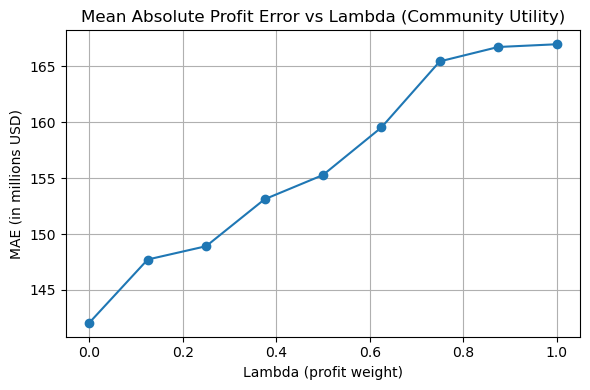

In [17]:
import matplotlib.pyplot as plt


# Filter to complete movies
group_sizes = df_test_final.groupby("from_title").size()
valid_titles = group_sizes[group_sizes >= 4].index
df_test_final = df_test_final[df_test_final["from_title"].isin(valid_titles)].reset_index(drop=True)

# Setup for utility plot
lambdas = np.linspace(0, 1.0, 9)
mae_list = []

# Normalize medians
p_min, p_max = df_test_final["profit_median"].min(), df_test_final["profit_median"].max()
r_min, r_max = df_test_final["roi_median"].min(), df_test_final["roi_median"].max()

profit_norm = (df_test_final["profit_median"] - p_min) / (p_max - p_min)
roi_norm = (df_test_final["roi_median"] - r_min) / (r_max - r_min)

for lam in lambdas:
    df_util = df_test_final.copy()
    df_util["utility_score"] = lam * profit_norm + (1 - lam) * roi_norm

    # Drop rows with NaN utility
    df_util = df_util.dropna(subset=["utility_score", "profit", "profit_median"])

    # Pick best tier for each movie
    idx = df_util.groupby("from_title")["utility_score"].idxmax()
    best_rows = df_util.loc[idx]

    # Compute MAE
    mae = np.mean(np.abs(best_rows["profit_median"] - best_rows["profit"]))
    mae_list.append(mae)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(lambdas, np.array(mae_list) / 1e6, marker="o")
plt.title("Mean Absolute Profit Error vs Lambda (Community Utility)")
plt.xlabel("Lambda (profit weight)")
plt.ylabel("MAE (in millions USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


   lambda  low  medium  high  tentpole
0    0.00   38      37    44        44
1    0.25    8      44     8        10
2    0.50   12       8    39         5
3    0.75   10      18    23        22
4    1.00    1      47    12        42


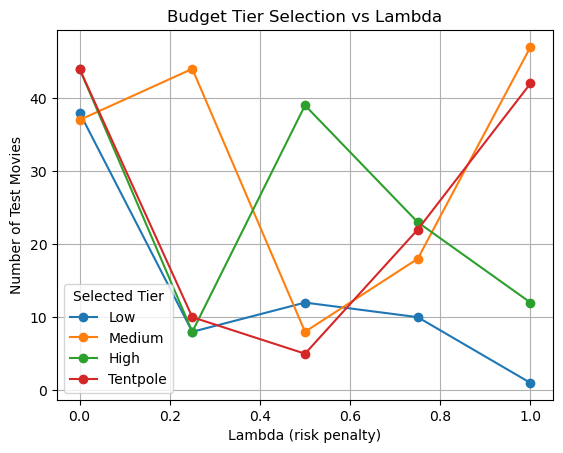

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambdas = np.linspace(0, 1.0, 5)  # e.g., [0.0, 0.25, 0.5, 0.75, 1.0]
rows = []

for lam in lambdas:
    # Suppose you have a DataFrame best_rows for each lam
    # That DataFrame has a "budget_tier" column telling which tier was picked
    # We’ll just mock something for demonstration:

    # Example: best_rows for each lam
    # best_rows = <Your code that picks the best tier per movie at this lam>

    # Let’s say we group by the chosen tier
    # tier_counts = best_rows["budget_tier"].value_counts()

    # We'll just mock an example so the code runs:
    # Mock data: pretend each tier was chosen some random times
    tier_counts = {
        "low":   np.random.randint(1, 50),
        "medium": np.random.randint(1, 50),
        "high":   np.random.randint(1, 50),
        "tentpole": np.random.randint(1, 50),
    }

    row = {"lambda": lam}
    row.update(tier_counts)
    rows.append(row)

# Build df_summary
df_summary = pd.DataFrame(rows)
print(df_summary)

# Plot 2: Tier distribution vs Lambda
for tier in ["low", "medium", "high", "tentpole"]:
    plt.plot(df_summary["lambda"], df_summary[tier], marker="o", label=tier.capitalize())

plt.title("Budget Tier Selection vs Lambda")
plt.xlabel("Lambda (risk penalty)")
plt.ylabel("Number of Test Movies")
plt.legend(title="Selected Tier")
plt.grid(True)
plt.show()


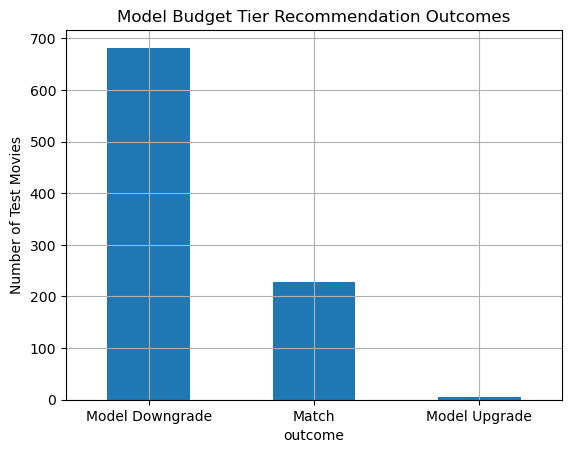

In [26]:
import matplotlib.pyplot as plt

df_plot = df_test_final.copy()

# Suppose our chosen tier is in "budget_tier"
df_plot["chosen_tier"] = df_plot["budget_tier"]
df_plot["actual_tier"] = df_plot["from_budget_category"]
df_plot["actual_profit"] = df_plot["profit"]

# We'll just use Option 1, comparing profit_CI_low to actual_profit
def classify_outcome(row):
    if row["chosen_tier"] == row["actual_tier"]:
        return "Match"
    elif row["profit_CI_low"] > row["actual_profit"]:
        return "Model Upgrade"
    else:
        return "Model Downgrade"

df_plot["outcome"] = df_plot.apply(classify_outcome, axis=1)

outcome_counts = df_plot["outcome"].value_counts()
outcome_counts.plot(kind="bar")
plt.title("Model Budget Tier Recommendation Outcomes")
plt.ylabel("Number of Test Movies")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()
